In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\juand\.cache\kagglehub\datasets\abdallahalidev\plantvillage-dataset\versions\3


# Imports y ruta

In [9]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

## Verificación de Dimensiones de Imágenes

Esta función verifica si todas las imágenes en un directorio tienen las mismas dimensiones. Es útil para asegurar la consistencia del dataset antes de entrenar modelos de machine learning, especialmente cuando se requiere que todas las imágenes tengan el mismo tamaño (como 256x256 píxeles).


In [3]:
def verificar_dimensiones_imagenes(directorio, dimensiones_esperadas=(256, 256)):
    """
    Verifica si todas las imágenes en un directorio tienen las mismas dimensiones.
    
    Args:
        directorio (str): Ruta al directorio que contiene las imágenes
        dimensiones_esperadas (tuple): Dimensiones esperadas (ancho, alto). Default: (256, 256)
    
    Returns:
        dict: Diccionario con información sobre la verificación
    """
    import os
    from PIL import Image
    
    # Obtener lista de archivos de imagen
    extensiones_validas = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.JPG', '.JPEG', '.PNG')
    archivos_imagen = [f for f in os.listdir(directorio) if f.endswith(extensiones_validas)]
    
    if not archivos_imagen:
        return {"error": "No se encontraron archivos de imagen en el directorio"}
    
    # Verificar cada imagen
    dimensiones_encontradas = set()
    imagenes_problematicas = []
    total_imagenes = len(archivos_imagen)
    
    for archivo in archivos_imagen:
        try:
            ruta_completa = os.path.join(directorio, archivo)
            with Image.open(ruta_completa) as img:
                dimensiones = img.size  # (ancho, alto)
                dimensiones_encontradas.add(dimensiones)
                
                if dimensiones != dimensiones_esperadas:
                    imagenes_problematicas.append({
                        'archivo': archivo,
                        'dimensiones': dimensiones,
                        'esperadas': dimensiones_esperadas
                    })
        except Exception as e:
            imagenes_problematicas.append({
                'archivo': archivo,
                'error': str(e)
            })
    
    # Resultados
    todas_iguales = len(dimensiones_encontradas) == 1
    dimensiones_correctas = todas_iguales and list(dimensiones_encontradas)[0] == dimensiones_esperadas
    
    return {
        'total_imagenes': total_imagenes,
        'dimensiones_esperadas': dimensiones_esperadas,
        'dimensiones_encontradas': list(dimensiones_encontradas),
        'todas_iguales': todas_iguales,
        'dimensiones_correctas': dimensiones_correctas,
        'imagenes_problematicas': imagenes_problematicas,
        'porcentaje_correcto': ((total_imagenes - len(imagenes_problematicas)) / total_imagenes) * 100
    }

# Ejemplo de uso
resultado = verificar_dimensiones_imagenes("plantvillage dataset/color/Potato___Early_blight")
print(f"Total de imágenes: {resultado['total_imagenes']}")
print(f"Dimensiones encontradas: {resultado['dimensiones_encontradas']}")
print(f"Todas tienen las mismas dimensiones: {resultado['todas_iguales']}")
print(f"Dimensiones correctas (256x256): {resultado['dimensiones_correctas']}")
print(f"Porcentaje correcto: {resultado['porcentaje_correcto']:.1f}%")

if resultado['imagenes_problematicas']:
    print(f"\nImágenes problemáticas: {len(resultado['imagenes_problematicas'])}")
    for img in resultado['imagenes_problematicas'][:5]:  # Mostrar solo las primeras 5
        print(f"  - {img['archivo']}: {img.get('dimensiones', 'Error al cargar')}")


Total de imágenes: 1000
Dimensiones encontradas: [(256, 256)]
Todas tienen las mismas dimensiones: True
Dimensiones correctas (256x256): True
Porcentaje correcto: 100.0%


## Estructura de una Imagen Digital

### Dimensiones de una Imagen (256, 256, 3)

Una imagen digital se representa como un **tensor de 3 dimensiones**:

1. **Primera dimensión (256)**: **Filas** - Altura de la imagen en píxeles
2. **Segunda dimensión (256)**: **Columnas** - Ancho de la imagen en píxeles  
3. **Tercera dimensión (3)**: **Canales de color** - RGB (Red, Green, Blue)

### ¿Qué es un canal de color?

Cada píxel de una imagen a color se compone de **3 valores**:
- **Canal Rojo (R)**: Intensidad del rojo (0-255)
- **Canal Verde (G)**: Intensidad del verde (0-255)
- **Canal Azul (B)**: Intensidad del azul (0-255)

### Estructura de la Matriz

```
Imagen[256, 256, 3] = [
  [píxel(0,0) = [R, G, B], píxel(0,1) = [R, G, B], ..., píxel(0,255) = [R, G, B]],
  [píxel(1,0) = [R, G, B], píxel(1,1) = [R, G, B], ..., píxel(1,255) = [R, G, B]],
  ...
  [píxel(255,0) = [R, G, B], píxel(255,1) = [R, G, B], ..., píxel(255,255) = [R, G, B]]
]
```

### Ejemplo Práctico

Si tienes un píxel en la posición (100, 150):
- `imagen[100, 150, 0]` = Valor del canal Rojo
- `imagen[100, 150, 1]` = Valor del canal Verde  
- `imagen[100, 150, 2]` = Valor del canal Azul
- `imagen[100, 150, :]` = [R, G, B] completo del píxel


In [5]:
# =================== CONFIGURACIÓN =====================
root_dir = "plantvillage dataset/color"
# Orden de clases FIJO (debe usarse igual en entrenamiento e inferencia)
class_names_used = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"
]

img_size_raw = (256, 256)   # tamaño de carga desde disco
target_size = (128, 128)    # tamaño para el MLP (reduce parámetros)
val_split = 0.2
seed = 42
batch = 32
num_classes = len(class_names_used)

# ================== DATASET (RAW, CON ETIQUETAS) ==================
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names_used,
    image_size=img_size_raw,
    color_mode="rgb",
    validation_split=val_split,
    subset="training",
    seed=seed,
    shuffle=True,
    batch_size=batch,
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names_used,
    image_size=img_size_raw,
    color_mode="rgb",
    validation_split=val_split,
    subset="validation",
    seed=seed,
    shuffle=False,
    batch_size=batch,
)

print("Orden de clases (fijo):", class_names_used)

# ========== PREPROCESAMIENTO PARA ENTRENAR EL MLP (MAP) ===========
# Resize -> float32 -> normalizar si rango >1 -> aplanar
@tf.function
def preprocess_batch_for_mlp(x, y):
    x = tf.image.resize(x, target_size)
    x = tf.cast(x, tf.float32)
    # Normalizar a [0,1] solo si llegan en [0,255]
    maxv = tf.reduce_max(x, axis=[1,2,3], keepdims=True)
    x = tf.where(maxv > 1.0, x / 255.0, x)
    # Aplanar (B, H*W*C)
    x = tf.reshape(x, (tf.shape(x)[0], -1))
    return x, tf.cast(y, tf.int32)

train_ds_pp = train_ds_raw.map(preprocess_batch_for_mlp, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(8192, seed=seed).prefetch(tf.data.AUTOTUNE)
val_ds_pp   = val_ds_raw.map(preprocess_batch_for_mlp,   num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

# ======================== MODELO MLP =========================
reg = tf.keras.regularizers.l2(1e-4)
inputs = tf.keras.Input(shape=(target_size[0]*target_size[1]*3,))
x = tf.keras.layers.BatchNormalization()(inputs)
x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]

# Ponderación por desbalance (opcional)
# Estimación aproximada desde train_ds_raw (puede tardar un poco)
counts = np.zeros(num_classes, dtype=np.int64)
for _, yb in train_ds_raw.unbatch().batch(4096):
    y_np = yb.numpy()
    for i in range(num_classes):
        counts[i] += np.sum(y_np == i)
class_weights = {i: float(np.sum(counts)/max(counts[i],1)) for i in range(num_classes)}
print("Distribución clases (train):", dict(zip(class_names_used, counts.tolist())))
print("Class weights:", class_weights)

history = model.fit(
    train_ds_pp,
    validation_data=val_ds_pp,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights,  
    verbose=1,
)



Found 3852 files belonging to 4 classes.
Using 3082 files for training.
Found 3852 files belonging to 4 classes.
Using 770 files for validation.
Orden de clases (fijo): ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight']
Distribución clases (train): {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 427, 'Corn_(maize)___Common_rust_': 942, 'Corn_(maize)___healthy': 950, 'Corn_(maize)___Northern_Leaf_Blight': 763}
Class weights: {0: 7.217798594847775, 1: 3.2717622080679405, 2: 3.2442105263157894, 3: 4.039318479685452}
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 497ms/step - accuracy: 0.7579 - loss: 3.0762 - val_accuracy: 0.1558 - val_loss: 2.7370 - learning_rate: 0.0010
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 489ms/step - accuracy: 0.8381 - loss: 2.2144 - val_accuracy: 0.6727 - val_loss: 1.1200 - learning_rate: 0.0010
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.8

In [ ]:
# ================== MODELO DE INFERENCIA ENVUELTO ==================
# Acepta (B,H,W,3) o (H,W,3) y aplica el mismo preprocesamiento internamente
from tensorflow.keras import layers
TARGET_SIZE = (128, 128)
inp = keras.Input(shape=(None, None, 3))                 # imagen RGB arbitraria
z = layers.Resizing(TARGET_SIZE[0], TARGET_SIZE[1])(inp) # <-- en vez de tf.image.resize
z = layers.Rescaling(1./255)(z)                          # normaliza a [0,1]
z = layers.Flatten()(z)                                  # aplanar para el MLP
out = model(z)                                           # usa tu MLP ya entrenado
model_infer = keras.Model(inp, out)
model_infer.compile(
    optimizer=model.optimizer,               # reuse optimizer
    loss="sparse_categorical_crossentropy",  # labels are ints
    metrics=["accuracy"]
)
# ======================== EVALUACIÓN =========================
# Evalúa directamente sobre val_ds_raw (uint8, [0..255]); model_infer normaliza dentro
test_loss, test_acc = model_infer.evaluate(val_ds_raw, verbose=1)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

# ============== PREDICCIÓN DE UNA IMAGEN EXTERNA =============
def predict_external_image(image_path: str):
    raw = tf.io.read_file(image_path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)  # RGB
    probs = model_infer.predict(img[None, ...], verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names_used[pred_idx]

    plt.imshow(img.numpy().astype(np.uint8)); plt.axis('off')
    plt.title(f"Pred: {pred_name} (p={probs[pred_idx]:.2f})")
    plt.show()
    return pred_name, probs


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9273 - loss: 0.7095
Test loss: 0.7095332741737366
Test accuracy: 0.9272727370262146


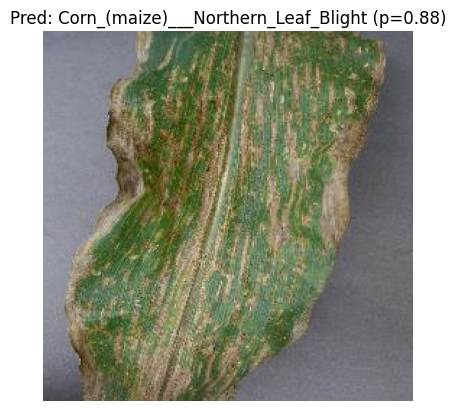

Probs: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0.1215328574180603, 'Corn_(maize)___Common_rust_': 0.00012794890790246427, 'Corn_(maize)___healthy': 1.767093999660574e-05, 'Corn_(maize)___Northern_Leaf_Blight': 0.8783215284347534}


('Corn_(maize)___Northern_Leaf_Blight',
 array([1.2153286e-01, 1.2794891e-04, 1.7670940e-05, 8.7832153e-01],
       dtype=float32))

In [12]:

dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot"
specific_img = "00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.JPG"
early_blight = os.path.join(dataset_path, vegetable_leaf, specific_img)
# Ejecuta
predict_external_image(early_blight)

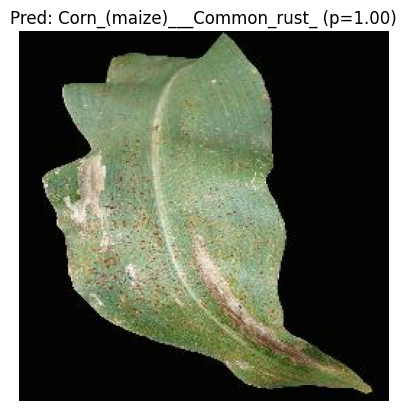

Probs: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 2.6803040782397147e-06, 'Corn_(maize)___Common_rust_': 0.9999971389770508, 'Corn_(maize)___healthy': 1.9731347222773366e-08, 'Corn_(maize)___Northern_Leaf_Blight': 9.820931978765657e-08}


('Corn_(maize)___Common_rust_',
 array([2.6803041e-06, 9.9999714e-01, 1.9731347e-08, 9.8209320e-08],
       dtype=float32))

In [13]:
dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Corn_(maize)___Common_rust_"
specific_img = "RS_Rust 1563.JPG"

late_blight = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(late_blight)

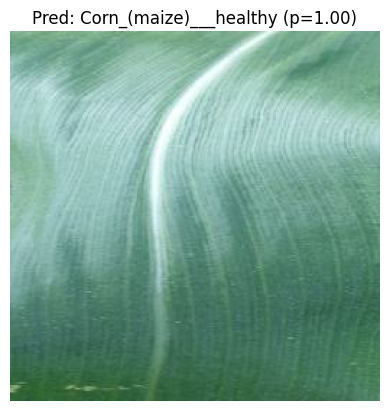

Probs: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 2.861862640202162e-07, 'Corn_(maize)___Common_rust_': 3.8916321500437334e-05, 'Corn_(maize)___healthy': 0.9999606609344482, 'Corn_(maize)___Northern_Leaf_Blight': 1.8102535648267803e-07}


('Corn_(maize)___healthy',
 array([2.8618626e-07, 3.8916322e-05, 9.9996066e-01, 1.8102536e-07],
       dtype=float32))

In [14]:

dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Corn_(maize)___healthy"
specific_img = "0a1a49a8-3a95-415a-b115-4d6d136b980b___R.S_HL 8216 copy.JPG"

late_blight_2 = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(late_blight_2)

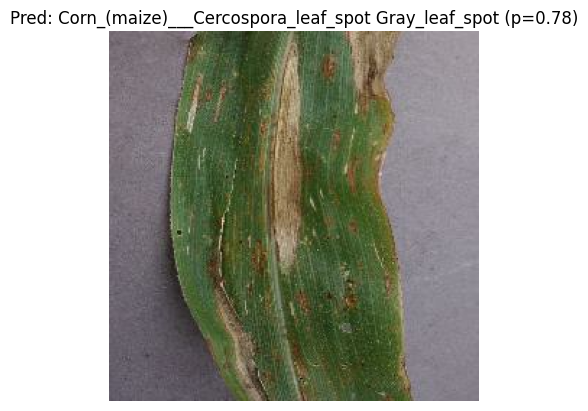

Probs: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0.7819204926490784, 'Corn_(maize)___Common_rust_': 9.933913133863825e-06, 'Corn_(maize)___healthy': 4.957132478011772e-05, 'Corn_(maize)___Northern_Leaf_Blight': 0.2180200219154358}


('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 array([7.8192049e-01, 9.9339131e-06, 4.9571325e-05, 2.1802002e-01],
       dtype=float32))

In [11]:

dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Corn_(maize)___Northern_Leaf_Blight"
specific_img = "00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG"

Healthy = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(Healthy)